In [1]:
import time
import os
import re
import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

os.chdir('/home/s44grp/shared/s44hy/mrv3')

In [3]:
import sys
sys.path.insert(1, '/opt/anaconda/anaconda-2.0.0/envs/PY36_R35/lib/python3.6/site-packages')
import tensorflow
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

## Part 1: Load Image

In [8]:
EPOCHS = 20
BATCH_SIZE = 50
LR_RT = 1e-4
IMG_DIR = 'scripts3/test_cnn/converted_imagesPearson_full'
MODEL_DIR = 'scripts3/test_cnn/model_full'

train = ImageDataGenerator(rescale = 1./255)
train_dataset = train.flow_from_directory(
    directory = IMG_DIR + '/data/train',
    target_size = (38,38),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True)

valid = ImageDataGenerator(rescale = 1./255)
valid_dataset = train.flow_from_directory(
    directory = IMG_DIR + '/data/valid',
    target_size = (38,38),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False)

Found 21534 images belonging to 2 classes.
Found 2236 images belonging to 2 classes.


## Part 2: CNN Modeling
### step 1: architecture

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, ZeroPadding2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from keras.regularizers import l1, l2, l1_l2
from keras.optimizers import RMSprop, Adam

model = Sequential()

model.add(Conv2D(16,(3,3), activation='relu', padding='same', input_shape=(38,38,3)))
model.add(Conv2D(16,(3,3), activation='relu', padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(ZeroPadding2D())

model.add(Conv2D(32,(3,3), activation='relu', padding='same', use_bias=True))
model.add(Conv2D(32,(3,3), activation='relu', padding='same', use_bias=True))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3), activation='relu', padding='same', use_bias=True))
model.add(Conv2D(64,(3,3), activation='relu', padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(ZeroPadding2D())

model.add(Conv2D(128,(3,3), activation='relu', padding='same', use_bias=True))
model.add(Conv2D(128,(3,3), activation='relu', padding='same', use_bias=True))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3), activation='relu', padding='same', use_bias=True))
model.add(Conv2D(64,(3,3), activation='relu', padding='same', use_bias=True))
model.add(Conv2D(64,(3,3), activation='relu', padding='same', use_bias=True))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3), activation='relu', padding='same', use_bias=True))
model.add(Conv2D(64,(3,3), activation='relu', padding='same', use_bias=True))
model.add(Conv2D(64,(3,3), activation='relu', padding='same', use_bias=True))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu', use_bias=True))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', use_bias=True))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', use_bias=True))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer = RMSprop(lr = LR_RT), 
              loss = 'binary_crossentropy',   
              metrics = ['accuracy']) # to evaluate only

### step 2: callbacks

In [10]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 3, 
    min_lr = 1e-7)

checkpoint = ModelCheckpoint(
    filepath = os.path.join(MODEL_DIR, 'model_{epoch:02d}.h5'),
    monitor = 'val_acc',
    save_best_only = False,
    save_weights_only = False)

### step 3: train

In [11]:
start = time.time()
model.fit_generator(
    train_dataset, 
    steps_per_epoch = train_dataset.n // BATCH_SIZE, 
    epochs = EPOCHS, 
    validation_data = valid_dataset,
    validation_steps = valid_dataset.n // BATCH_SIZE,
    callbacks = [reduce_lr, checkpoint])
end = time.time()
print(f'Running Time: {(end - start)/3600} hrs.')

Epoch 1/20
430/430 [==============================] - 372s 865ms/step - loss: 0.6649 - acc: 0.6119 - val_loss: 0.6081 - val_acc: 0.6698
Epoch 2/20
430/430 [==============================] - 364s 846ms/step - loss: 0.6328 - acc: 0.6494 - val_loss: 0.6108 - val_acc: 0.6924
Epoch 3/20
430/430 [==============================] - 363s 844ms/step - loss: 0.6175 - acc: 0.6625 - val_loss: 0.6551 - val_acc: 0.6215
Epoch 4/20
430/430 [==============================] - 366s 850ms/step - loss: 0.6085 - acc: 0.6739 - val_loss: 0.6446 - val_acc: 0.6818
Epoch 5/20
430/430 [==============================] - 365s 849ms/step - loss: 0.5799 - acc: 0.7015 - val_loss: 0.5694 - val_acc: 0.7072
Epoch 6/20
430/430 [==============================] - 358s 832ms/step - loss: 0.5581 - acc: 0.7161 - val_loss: 0.5783 - val_acc: 0.7049
Epoch 7/20
430/430 [==============================] - 359s 835ms/step - loss: 0.5321 - acc: 0.7327 - val_loss: 0.5784 - val_acc: 0.7022
Epoch 8/20
430/430 [============================

Running Time: 1.8879154955678517 hrs.


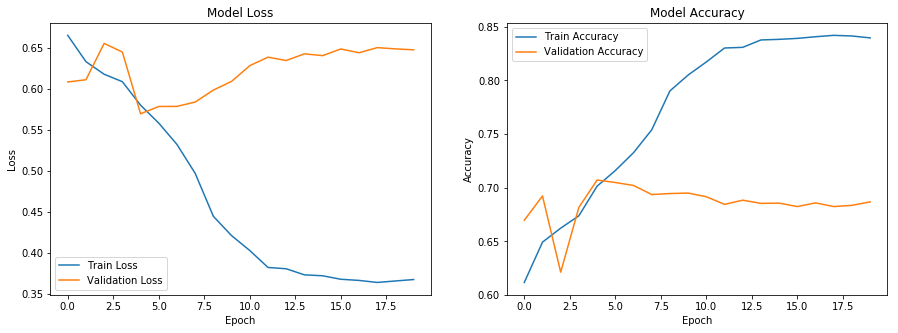

In [18]:
import matplotlib.pyplot as plt

history = model.history
fig, ax = plt.subplots(1, 2, figsize = (15,5))
_= ax[0].set_title('Model Loss')
_= ax[0].plot(history.epoch, history.history['loss'], label = 'Train Loss')
_= ax[0].plot(history.epoch, history.history['val_loss'], label = 'Validation Loss')
_= ax[0].set_ylabel('Loss')
_= ax[0].set_xlabel('Epoch')
_= ax[0].legend()
_= ax[1].set_title('Model Accuracy')
_= ax[1].plot(history.epoch, history.history['acc'], label = 'Train Accuracy')
_= ax[1].plot(history.epoch, history.history['val_acc'], label = 'Validation Accuracy')
_= ax[1].set_ylabel('Accuracy')
_= ax[1].set_xlabel('Epoch')
_= ax[1].legend()
plt.show()

### step 5: predict 

In [19]:
from keras.models import load_model
# model = load_model(MODEL_DIR + '/model_20.h5')

valid_dataset.reset()
probs = model.predict_generator(valid_dataset, valid_dataset.n/valid_dataset.batch_size)
preds = np.argmax(probs, axis = 1)

# labels = (train_dataset.class_indices)
# labels2 = dict((v,k) for k, v in labels.items())
# predictions = [labels2[k] for k in preds]
# results = pd.DataFrame({'image ID': valid_dataset.filenames, 'Predictions': predictions})

### step 6: evaluate

In [20]:
from sklearn.metrics import roc_auc_score, cohen_kappa_score, precision_score, \
recall_score, confusion_matrix

yvalid = valid_dataset.classes

print("ROC_AUC = {}".format(roc_auc_score(yvalid, preds)))
print("Cohen Kappa = {}".format(cohen_kappa_score(yvalid, preds)))
print("Precision= {}".format(precision_score(yvalid, preds, average='macro')))
print("Recall = {}".format(recall_score(yvalid, preds, average='macro')))

tn, fp, fn, tp = confusion_matrix(yvalid, preds).ravel()
specificity = tn / (tn+fp)
sensitivity= tp / (tp+ fn)
print("specificity = {}".format(specificity))
print("sensitivity = {}".format(sensitivity))

ROC_AUC = 0.6839236795616888
Cohen Kappa = 0.3677573240633054
Precision= 0.6842168316506383
Recall = 0.6839236795616888
specificity = 0.7050359712230215
sensitivity = 0.6628113879003559
